# Get Data

In [1]:
import os

data_dir = "./parsed_chat_data.csv"

if not os.path.exists(data_dir):
  # !wget https://raw.githubusercontent.com/stran123/6.864-final-project/main/data/mini_parsed_data.csv -O ./mini_data.csv
  !wget https://raw.githubusercontent.com/stran123/6.864-final-project/main/data/parsed_chat_data.zip -O ./parsed_chat_data.zip
  !unzip parsed_chat_data.zip -d .

--2021-05-06 07:50:18--  https://raw.githubusercontent.com/stran123/6.864-final-project/main/data/parsed_chat_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10794217 (10M) [application/zip]
Saving to: ‘./parsed_chat_data.zip’

./parsed_chat_data. 100%[===================>]  10.29M  53.3MB/s    in 0.2s    

2021-05-06 07:50:19 (53.3 MB/s) - ‘./parsed_chat_data.zip’ saved [10794217/10794217]

Archive:  parsed_chat_data.zip
  inflating: ./parsed_chat_data.csv  
  inflating: ./__MACOSX/._parsed_chat_data.csv  


# Read Data

In [2]:
import pandas as pd
import spacy
from tqdm.notebook import tqdm

df = pd.read_csv(data_dir)
df = df[['conversation_id','message','parsed_msg']][:]

# Add START and PAD tokens. Split data into train/val

In [3]:
START=['[start]']
PAD=['[pad]']

longest_msg = max(df['parsed_msg'], key=lambda x: len(str(x).strip().split(' '))).split(' ')
num_convos = max(df['conversation_id'], key=lambda x: int(x))

train_data = []
valid_data = []
vocab = {START[0], PAD[0]}
prev_conv_id = 0
training_over = False
training_split = 0.8

for conv_id, msg, parsed_msg in df.values:
  if conv_id > num_convos*0.8:
    training_over = True

  if prev_conv_id != conv_id:
    if not training_over:
      train_data.append(START+PAD*(len(longest_msg)-1))
    else:
      valid_data.append(START+PAD*(len(longest_msg)-1))
    prev_conv_id = conv_id

  parsed_msg_split = str(parsed_msg).strip().lower().split(' ')
  vocab |= set(parsed_msg_split)

  if not training_over:
    train_data.append(str(parsed_msg).strip().split(' ')+PAD*(len(longest_msg)-len(parsed_msg_split)))
  else:
    valid_data.append(str(parsed_msg).strip().split(' ')+PAD*(len(longest_msg)-len(parsed_msg_split)))

In [4]:
vocab = list(vocab)
vocab_oh = {w:i for i,w in enumerate(vocab)}
train_data_encoded = []
valid_data_encoded = []

for msg in train_data:
  msg_vectorized = []
  for word in msg:
    msg_vectorized.append(vocab_oh[word.lower()])
  train_data_encoded.append(msg_vectorized)

for msg in valid_data:
  msg_vectorized = []
  for word in msg:
    msg_vectorized.append(vocab_oh[word.lower()])
  valid_data_encoded.append(msg_vectorized)

# Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Embedder(nn.Module):
  def __init__(self, num_words, num_layers, hidden_size, dropout=0):
    super(Embedder, self).__init__()

    self.embedding = nn.Embedding(num_words, hidden_size)

    self.lstm = nn.LSTM(input_size=hidden_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        batch_first=True,
                        dropout=dropout,
                        bidirectional=True)
  
  def forward(self, x):
    x = self.embedding(x)
    outputs, hidden = self.lstm(x)
    return outputs

In [6]:
class Predictor(nn.Module):
    
  def __init__(self, num_words, num_layers, hidden_size, dropout=0):
    super(Predictor, self).__init__()
    self.embedder = Embedder(num_words, num_layers, hidden_size)
    self.hidden_size = hidden_size
    self.dropout = nn.Dropout(dropout)
    self.lstm = nn.LSTM(input_size=2*hidden_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        batch_first=True,
                        dropout=dropout,
                        bidirectional=True)
    self.proj = nn.Linear(2*hidden_size, num_words, bias=True)
  
  def forward(self, x):
    word_embeddings = self.embedder(x)
    word_embeddings = self.dropout(word_embeddings)
    output, (_, _) = self.lstm(word_embeddings)
    decoded_output = self.proj(output) # [batch_size, max_len, vocab_size]
    # return decoded_output
    return F.log_softmax(decoded_output, dim=2) # [batch_size, max_len, vocab_size]

# Inputs

In [7]:
model = Predictor(len(vocab), 1, 1024)
inputt = torch.tensor(train_data_encoded[1:3])
y = model(inputt)
y = torch.argmax(y, dim=2)

In [8]:
print(y)
print(y.shape)
for idx,inp,output in zip(range(len(inputt)), y, inputt):
  print(idx)
  print(" ".join([vocab[idx] for idx in output]))
  print(" ".join([vocab[idx] for idx in inp]))
  

tensor([[ 6942,  5305, 21644, 26783, 26783, 36559, 15148, 12115, 14852, 13403,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,  2607,
          2607,  2607,  2607,  2607,  2607,  2607,  

## Hyperparameters

In [10]:
batch_size = 32
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
loss_fn = nn.NLLLoss(reduction="sum", ignore_index=vocab_oh['[pad]'])
dropout = 0.3
epochs = 2
hidden_size = 1024
embedder_layers = 1

# Training

In [11]:
import random
from tqdm.notebook import tqdm
random.seed(0)

model = Predictor(len(vocab), embedder_layers, hidden_size, dropout)

training_data_x = torch.tensor(train_data_encoded)
validation_data_x = torch.tensor(valid_data_encoded)

training_data_y = torch.cat((training_data_x[1:,:], training_data_x[0:1,:]), axis=0)
validation_data_y = torch.cat((validation_data_x[1:,:], validation_data_x[0:1,:]), axis=0)

training_data = list(zip(training_data_x, training_data_y))
validation_data = list(zip(validation_data_x, validation_data_y))

random.shuffle(training_data)
random.shuffle(validation_data)

training_data = training_data[:10000]
validation_data = validation_data[:1000]

## Training Model

In [14]:
model = Predictor(len(vocab), embedder_layers, hidden_size, dropout)
losses = []
print_every = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
model.to(device)

for epoch in tqdm(range(epochs)):
  model.train()
  for batch in tqdm(range(int(len(training_data)/batch_size))):
    batch_data = training_data[batch*batch_size:(batch+1)*batch_size]
    x, y = zip(*batch_data)
    x, y = torch.cat(x, dim=0).reshape(batch_size, -1), torch.cat(y, dim=0).reshape(batch_size, -1)
    y_pred = model(x.to(device))

    loss = 0
    for pred,label in zip(y_pred, y):
      loss += loss_fn(pred, label.to(device))
    if batch % print_every == 0:
      print(f"Train Loss: {loss.item()}")
    losses.append(loss)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  if epoch % 1 == 0: # evaluate model
    model.eval()
    loss = 0
    with torch.no_grad():
      for batch in tqdm(range(int(len(validation_data)/batch_size))):
        batch_data = validation_data[batch*batch_size:(batch+1)*batch_size]
        x, y = zip(*batch_data)
        x, y = torch.cat(x, dim=0).reshape(batch_size, -1), torch.cat(y, dim=0).reshape(batch_size, -1)
        y_pred = model(x.to(device))
        y_pred = y_pred.swapaxes(1, 2)
        # compare y_pred and y
        loss += loss_fn(y_pred, y.to(device))
    print(f"Test Loss: {loss.item()}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Train Loss: 8424.3828125
Train Loss: 9108.8056640625
Train Loss: 7324.21240234375
Train Loss: 8906.845703125
Train Loss: 6661.60498046875
Train Loss: 6354.533203125
Train Loss: 8022.68408203125
Train Loss: 7239.2568359375
Train Loss: 7166.12451171875
Train Loss: 9287.603515625
Train Loss: 8033.9482421875
Train Loss: 7420.87353515625
Train Loss: 8107.447265625
Train Loss: 6997.08984375
Train Loss: 7451.6181640625
Train Loss: 6745.44140625
Train Loss: 7557.13818359375
Train Loss: 7453.72802734375
Train Loss: 8296.841796875
Train Loss: 8751.10546875
Train Loss: 7378.1796875
Train Loss: 6745.92822265625
Train Loss: 8867.2265625
Train Loss: 7768.8486328125
Train Loss: 6162.6630859375
Train Loss: 9088.50390625
Train Loss: 8370.5478515625
Train Loss: 7356.6767578125
Train Loss: 7061.38623046875
Train Loss: 6458.49267578125
Train Loss: 7178.72216796875
Train Loss: 7452.25927734375




Test Loss: 239227.34375


Train Loss: 8423.9697265625
Train Loss: 9108.310546875
Train Loss: 7324.6943359375
Train Loss: 8906.8828125
Train Loss: 6661.97705078125
Train Loss: 6354.0537109375
Train Loss: 8023.4453125
Train Loss: 7239.21337890625
Train Loss: 7166.77294921875
Train Loss: 9288.1904296875
Train Loss: 8035.30126953125
Train Loss: 7420.9775390625
Train Loss: 8108.18212890625
Train Loss: 6996.4462890625
Train Loss: 7451.49658203125
Train Loss: 6744.79638671875
Train Loss: 7556.66015625
Train Loss: 7453.4765625
Train Loss: 8297.4091796875
Train Loss: 8750.880859375
Train Loss: 7378.1416015625
Train Loss: 6745.4912109375
Train Loss: 8867.056640625
Train Loss: 7769.494140625
Train Loss: 6162.408203125
Train Loss: 9088.0859375
Train Loss: 8370.525390625
Train Loss: 7356.4658203125
Train Loss: 7062.103515625
Train Loss: 6458.92919921875
Train Loss: 7178.8671875
Train Loss: 7452.501953125




Test Loss: 239227.34375



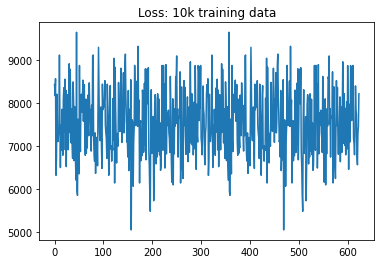

In [15]:
import matplotlib.pyplot as plt
plt.title("Loss: 10k training data")
plt.plot([_ for _ in range(len(losses))], losses)

In [350]:
import spacy
import torch

from collections import Counter

tokenizer = spacy.load('en_core_web_sm')

LONGEST_MSG_LENGTH = 50

# x = input("Say something to the bot:\n")
x = "are you a fan of google or microsoft ?"

PAD = ['[pad]']
tokenized_msg = tokenizer(x)
parsed_msg = ' '.join([token.text for token in tokenized_msg])
split_msg = parsed_msg.split(' ')

if len(split_msg) < LONGEST_MSG_LENGTH:
  padded_msg = split_msg + PAD*(LONGEST_MSG_LENGTH-len(split_msg))
else:
  raise ValueError("Message is too long!")

one_hotted_msg = torch.tensor(list(map(lambda word: vocab_oh[word], padded_msg))).unsqueeze(0)

model_out = model(one_hotted_msg.to(device))
y = torch.argmax(model_out, dim = 2)

output_msg = ' '.join([vocab[i] for i in y[0,:]])
print(output_msg)

dust nam proceed proceed stormy jacked autotune es theirselves theirselves behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf behalf quad estimate estimate
